# Day 10 Group Worksheet - Solutions
Oct 09, 2024

If you're working on CoCalc, it's good to rename your notebook with a fun group name and to include your names below so that you can easily find it later for reference.

* Group members:

## *1 Overview and additional `solve_ivp` details*

In today's group worksheet you will update your Electric Field Hockey code from the previous worksheet 09 to use `solve_ivp` instead of your `euler_method` function. You will then further revise your code as you tackle new Electric Field Hockey challenges.

Before we provide the new Electric Field Hockey challenges, let's look at some additional details related to events when using `solve_ivp`

### Using multiple events and extracting useful information about these events 

You may want to use multiple different conditions to trigger events and it is best practice to use a separate event function for each. For the examples below, `event1` will be detecred when `state[0]` crosses 0 and cause the simulation to stop. On the other hand we can make a non-terminal event (i.e., one that won't stop the solver) `event2` that triggers when `state[0] - 1` crosses 0, which is also the same as when `state[0]` crosses `1`.
```python
def event1(t, state):
    return state[0] 

event1.terminal = True # This event will stop the simulation
event1.direction = 0


def event2(t, state):
    return state[0]-1

event2.terminal = False # This event won't stop the simulation
event2.direction = 0


```
To include multiple event functions in `solve_ivp` we would use the following syntax
```python
sol = solve_ivp(diff_eqns, t_span, state0, t_eval=t_eval, events=[event1, event2])
```


Information about these events is returned as part of the solution object returned by `solve_ivp`. If our solution was `sol`, then the time information will be stored in `sol.t_events` and the state information in `sol.y_events`. 

**A very important reminder!!!** In `solve_ivp` solutions, `y` refers to the overall state and not just a position y. 

Continuing along with our example from above where we are using two event functions, `events=[event1, event2]`, we need to use indexing with `sol.t_events` and `sol.y_events` to access the information from a specific event function. For example: 
```python
t_event1 = sol.t_events[0]
state_event1 = sol.y_events[0]
```
and
```python
t_event2 = sol.t_events[2]
state_event2 = sol.y_events[2]
```
It is important to note in this example that `t_event1`, `state_event1`, `t_event2` and `state_event2` will all be arrays, because each event could have triggered multiple times, so you will have to further unpack the information in those arrays to extract the information you want.

## *2 Tasks*

### Task 1: Convert your Electric Field Hockey simulation to one that uses `solve_ivp`

Make use of the hints and additional details above to get your previous Electric Field Hockey simulation working using `solve_ivp` instead of `euler_method`.

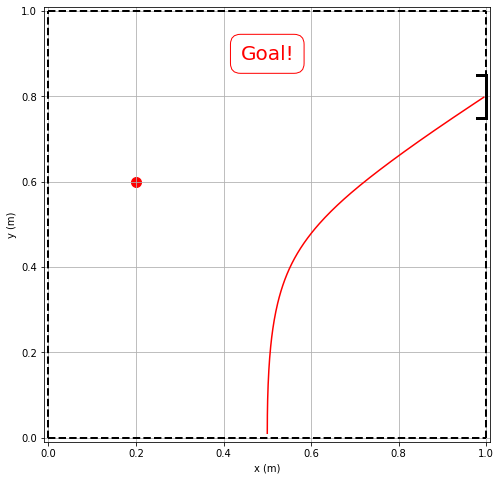

It is True that a goal was scored


In [1]:
# 4-event solution with a run_sim() function to run the code
# Also incluses a Task 3 solution

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

## Event functions for the four edges of the play area

def out_right(t, state):
    x, y, vx, vy = state
    return x-1
out_right.terminal = True
out_right.direction = 0 

def out_left(t, state):
    x, y, vx, vy = state
    return x
out_left.terminal = True
out_left.direction = 0 

def out_top(t, state):
    x, y, vx, vy = state
    return y-1
out_top.terminal = True
out_top.direction = 0 

def out_bottom(t, state):
    x, y, vx, vy = state
    return y
out_bottom.terminal = True
out_bottom.direction = 0 

# The physics
def diff_eqns(t, state):
    
    x, y, vx, vy = state
    
    fx, fy = 0, 0
    for charge in fixed_charges:
        r = np.sqrt((x - charge[0]) ** 2 + (y - charge[1]) ** 2)
        if charge[2] == 'r': 
            dir = 1.
        else:
            dir = -1.
        fx += dir * k * q**2 / r**3 * (x-charge[0])
        fy += dir * k * q**2 / r**3 * (y-charge[1])

    ax, ay = fx / m, fy / m
    
    return vx, vy, ax, ay

# Function that runs the sim
def run_sim():

    # Times to be simulated
    t0, tmax, dt = 0, 2, 0.001  # seconds
    n_steps = int((tmax-t0)/dt+1) 
    times = np.linspace(t0, tmax, n_steps)
    
    sol = solve_ivp(diff_eqns, [t0, tmax], state0, t_eval=times, 
                    events=[out_left, out_right, out_top, out_bottom])

    sol_t = sol.t
    sol_x = sol.y[0]
    sol_y = sol.y[1]

    # Check for goal
    x_final, y_final, t_final = sol_x[-1], sol_y[-1], sol_t[-1]
    if x_final > 0.99 and goal_dim[1][0] <= y_final <= goal_dim[1][1]:
        goal_text = "Goal!"
    else:
        goal_text = "No goal :("

    # Build the plot
    fig, ax = plt.subplots(figsize=(8, 8))

    ax.plot(sol_x, sol_y, color='r')
    ax.grid(True)

    # Draw sidelines and the goal
    for x1, y1, x2, y2 in [(1., 0, 1., 1), (0, 0, 0, 1), (0, 0, 1., 0), (0, 1., 1., 1.)]:
        ax.plot([x1, x2], [y1, y2], color='k', linestyle='--', linewidth=2)
    ax.plot([goal_dim[0][1], goal_dim[0][1]], [goal_dim[1][0], goal_dim[1][1]], color = 'k', linewidth = 3)
    ax.plot([goal_dim[0][0], goal_dim[0][1]], [goal_dim[1][1],goal_dim[1][1]], color = 'k', linewidth = 3)
    ax.plot([goal_dim[0][0], goal_dim[0][1]], [goal_dim[1][0], goal_dim[1][0]], color = 'k', linewidth = 3)

    # Plot fixed charges
    for charge in fixed_charges:
        ax.scatter(charge[0], charge[1], color=charge[2], s=100)

    # Set labels, limits, and show the plot
    ax.set_xlabel('x (m)')
    ax.set_ylabel('y (m)')
    ax.set_xlim([-0.01, 1.01])
    ax.set_ylim([-0.01, 1.01])

    plt.text(.5, .9, goal_text, color='red', ha='center', va='center', fontsize=20,
             bbox=dict(facecolor='white', edgecolor='red', boxstyle='round,pad=0.5'))

    plt.show()
    
    if goal_text == "Goal!":
        return True
    return False

### Load global constants into memory

# Constants
k = 8.9875517923e9  # Coulomb's constant; N*m^2/C^2
q = 1e-6  # Base charge is 1 uC
m = 1e-3  # Base mass is 1 g

# Initial conditions and parameters
state0 = (0.5, 0.01, 0.0, 6.2) # x0, y0, vx0, vy0
fixed_charges = [[0.2, 0.6, 'r']]  # Information about the fixed charges
goal_dim = [[.98, 1.],[.75, .85]]


goal_status = run_sim()
print ("It is", goal_status,"that a goal was scored" )


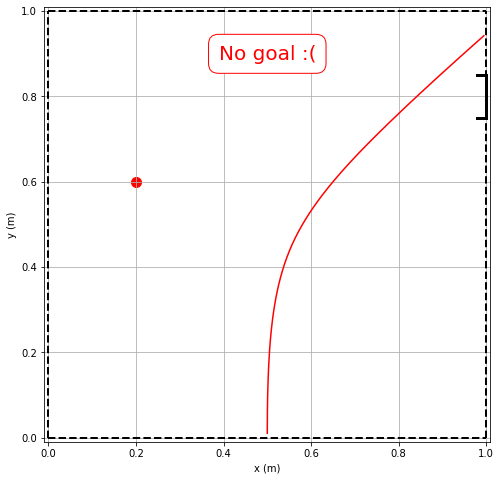

It is False that a goal was scored


In [2]:
# Use run_sim show "no goal" with different initial conditions
state0 = (0.5, 0.01, 0.0, 7.) # x0, y0, vx0, vy0
goal_status = run_sim()
print ("It is", goal_status,"that a goal was scored" )

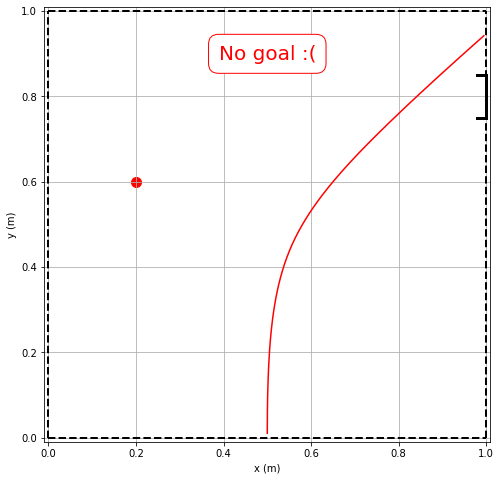

In [3]:
# 1-event solution with no run_sim function

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Constants
k = 8.9875517923e9  # Coulomb's constant; N*m^2/C^2
q = 1e-6  # Base charge is 1 uC
m = 1e-3  # Base mass is 1 g

## A single event function for all four edges of the play area
def out_all(t, state):
    x, y, vx, vy = state
    # All of these values will be positive when inside the box and
    # one of them will go negative when it leaves the box
    return min(x, 1-x, y, 1-y)
out_all.terminal = True
out_all.direction = 0 


# The physics
def diff_eqns(t, state):
    
    x, y, vx, vy = state
    
    fx, fy = 0, 0
    for charge in fixed_charges:
        r = np.sqrt((x - charge[0]) ** 2 + (y - charge[1]) ** 2)
        if charge[2] == 'r': 
            dir = 1.
        else:
            dir = -1.
        fx += dir * k * q**2 / r**3 * (x-charge[0])
        fy += dir * k * q**2 / r**3 * (y-charge[1])

    ax, ay = fx / m, fy / m
    
    return vx, vy, ax, ay

# Initial conditions and parameters
#state0 = [0.5, 0.01, 0.0, 6.2] # x0, y0, vx0, vy0
state0 = [0.5, 0.01, 0.0, 7] # x0, y0, vx0, vy0
fixed_charges = [[0.2, 0.6, 'r']]  # Information about the fixed charges
goal_dim = [[.98, 1.],[.75, .85]]

# Times to be simulated
t0, tmax, dt = 0, 2, 0.001  # seconds

t_span = (t0, tmax) # from t=0 to t=2
n_steps = int((tmax-t0)/dt+1) 
times = np.linspace(t0, tmax, n_steps) 

sol = solve_ivp(diff_eqns, [t0, tmax], state0, t_eval=times, 
                events=[out_all])

sol_t = sol.t
sol_x = sol.y[0]
sol_y = sol.y[1]

# Check for goal
x_final, y_final, t_final = sol_x[-1], sol_y[-1], sol_t[-1]
if x_final > 0.99 and goal_dim[1][0] <= y_final <= goal_dim[1][1]:
    goal_text = "Goal!"
else:
    goal_text = "No goal :("

# Build the plot
fig, ax = plt.subplots(figsize=(8, 8))

ax.plot(sol_x, sol_y, color='r')
ax.grid(True)

# Draw sidelines and the goal
for x1, y1, x2, y2 in [(1., 0, 1., 1), (0, 0, 0, 1), (0, 0, 1., 0), (0, 1., 1., 1.)]:
    ax.plot([x1, x2], [y1, y2], color='k', linestyle='--', linewidth=2)
ax.plot([goal_dim[0][1], goal_dim[0][1]], [goal_dim[1][0], goal_dim[1][1]], color = 'k', linewidth = 3)
ax.plot([goal_dim[0][0], goal_dim[0][1]], [goal_dim[1][1],goal_dim[1][1]], color = 'k', linewidth = 3)
ax.plot([goal_dim[0][0], goal_dim[0][1]], [goal_dim[1][0], goal_dim[1][0]], color = 'k', linewidth = 3)

# Plot fixed charges
for charge in fixed_charges:
    ax.scatter(charge[0], charge[1], color=charge[2], s=100)

# Set labels, limits, and show the plot
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
ax.set_xlim([-0.01, 1.01])
ax.set_ylim([-0.01, 1.01])

plt.text(.5, .9, goal_text, color='red', ha='center', va='center', fontsize=20,
         bbox=dict(facecolor='white', edgecolor='red', boxstyle='round,pad=0.5'))

plt.show()

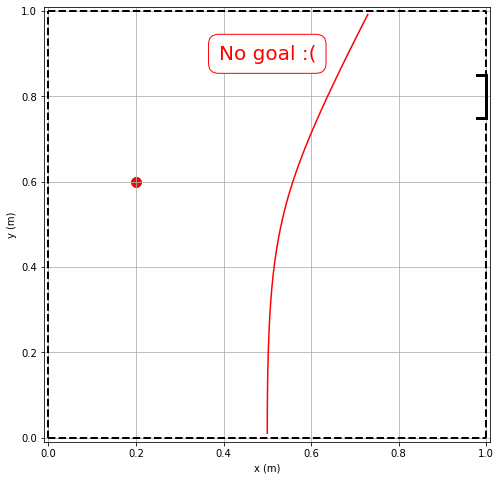

It is False that a goal was scored


In [4]:
# Solution that uses args to show how information can be passed 
# within the solve_ivp environment. Note that this version
# does not rely on any global variables

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

## Event functions for the four edges of the play area

def out_right(t, state, *args):
    x, y, vx, vy = state
    return x-1
out_right.terminal = True
out_right.direction = 0 

def out_left(t, state, *args):
    x, y, vx, vy = state
    return x
out_left.terminal = True
out_left.direction = 0 

def out_top(t, state, *args):
    x, y, vx, vy = state
    return y-1
out_top.terminal = True
out_top.direction = 0 

def out_bottom(t, state, *args):
    x, y, vx, vy = state
    return y
out_bottom.terminal = True
out_bottom.direction = 0 


# The physics
def diff_eqns(t, state, *args):
    
    x, y, vx, vy = state
    charges = args[0]
    k, q, m = args[1]
    
    fx, fy = 0, 0
    for charge in charges:
        r = np.sqrt((x - charge[0]) ** 2 + (y - charge[1]) ** 2)
        if charge[2] == 'r': 
            dir = 1.
        else:
            dir = -1.
        fx += dir * k * q**2 / r**3 * (x-charge[0])
        fy += dir * k * q**2 / r**3 * (y-charge[1])

    ax, ay = fx / m, fy / m
    
    return vx, vy, ax, ay

# Function that runs the sim
def run_sim2(state0, fixed_charges, goal_dim):

    # Constants
    k = 8.9875517923e9  # Coulomb's constant; N*m^2/C^2
    q0 = 1e-6  # Base charge is 1 uC
    m0 = 1e-3  # Base mass is 1 g
    constants = [k, q0, m0]    

    # Times to be simulated
    t0, tmax, dt = 0, 2, 0.001  # seconds
    t_span = (t0, tmax) # from t=0 to t=2
    n_steps = int((tmax-t0)/dt+1) 
    times = np.linspace(t0, tmax, n_steps) 
    
    sol = solve_ivp(diff_eqns, [t0, tmax], state0, 
                    t_eval=times, args=[fixed_charges, constants],
                    events=[out_left, out_right, out_top, out_bottom])

    sol_t = sol.t
    sol_x = sol.y[0]
    sol_y = sol.y[1]

    # Check for goal
    x_final, y_final, t_final = sol_x[-1], sol_y[-1], sol_t[-1]
    if x_final > 0.99 and goal_dim[1][0] <= y_final <= goal_dim[1][1]:
        goal_text = "Goal!"
    else:
        goal_text = "No goal :("

    # Build the plot
    fig, ax = plt.subplots(figsize=(8, 8))

    ax.plot(sol_x, sol_y, color='r')
    ax.grid(True)

    # Draw sidelines and the goal
    for x1, y1, x2, y2 in [(1., 0, 1., 1), (0, 0, 0, 1), (0, 0, 1., 0), (0, 1., 1., 1.)]:
        ax.plot([x1, x2], [y1, y2], color='k', linestyle='--', linewidth=2)
    ax.plot([goal_dim[0][1], goal_dim[0][1]], [goal_dim[1][0], goal_dim[1][1]], color = 'k', linewidth = 3)
    ax.plot([goal_dim[0][0], goal_dim[0][1]], [goal_dim[1][1],goal_dim[1][1]], color = 'k', linewidth = 3)
    ax.plot([goal_dim[0][0], goal_dim[0][1]], [goal_dim[1][0], goal_dim[1][0]], color = 'k', linewidth = 3)

    # Plot fixed charges
    for charge in fixed_charges:
        ax.scatter(charge[0], charge[1], color=charge[2], s=100)

    # Set labels, limits, and show the plot
    ax.set_xlabel('x (m)')
    ax.set_ylabel('y (m)')
    ax.set_xlim([-0.01, 1.01])
    ax.set_ylim([-0.01, 1.01])

    plt.text(.5, .9, goal_text, color='red', ha='center', va='center', fontsize=20,
             bbox=dict(facecolor='white', edgecolor='red', boxstyle='round,pad=0.5'))

    plt.show()
    
    if goal_text == "Goal!":
        return True
    return False


# Initial conditions and parameters
state0 = [0.5, 0.01, 0.0, 10] # x0, y0, vx0, vy0
fixed_charges = [[0.2, 0.6, 'r']]  # Information about the fixed charges
goal_dim = [[.98, 1.],[.75, .85]]

goal_status = run_sim2(state0, fixed_charges, goal_dim)
print ("It is", goal_status,"that a goal was scored" )

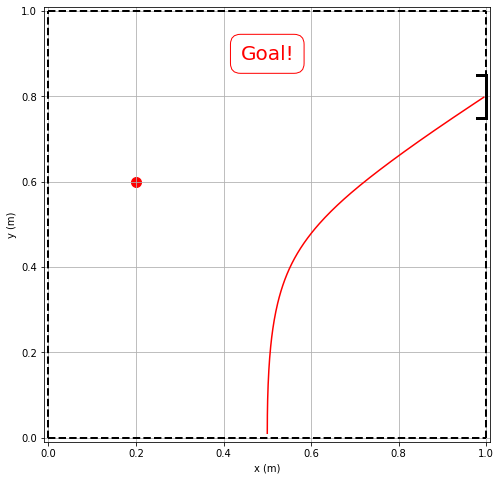

It is True that a goal was scored


In [5]:
# Use run_sim2 to score

state0 = [0.5, 0.01, 0.0, 6.2] # x0, y0, vx0, vy0
goal_status = run_sim2(state0, fixed_charges, goal_dim)
print ("It is", goal_status,"that a goal was scored" )

### Task 2: Score a goal around a barrier

Revise your simulation with new initial conditions and setup parameters detailed below.

* Change the initial state vector so that the moving charge starts at rest on the left-hand side of the play area, `state0 = [0.2, 0.5, 0.0, 0.0]`
* Move the goal down so that it is centered vertically, `goal_dim = [.45, .55, 1.] # y1, y2, x`
* Introduce a barrier, at `x = 0.6` and which spans `(y1, y2) = (0.35, 0.65)`. 

Your goals when completing this task are detailed below. Only the first one should be taken as a "must do", but the other two build further skills that we be very useful for Project 02.

1. (Must do) Figure out an arrangement of blue and red charges that will get the moving charge into the goal without hitting the barrier
1. (Good to do) Add "no goal" or "hit the barrier" feedback if the charge hits or passes through the location of the barrier
1. (Good to do) When the moving charge hits the barrier, make it so the simulation only draws the path up to the point. Note that it can be quite tricky to use a terminal event (`event.terminal = True`) to have the solver stop when it hits the barrier so you may wish to consider flagging the event without stopping the solver (`event.terminal = False`) and then make use of `sol.t_events` and `sol.y_events` after the solver has completed to figure out how much of the path to draw. However, it is possible to use `event.terminal = True` or `event.terminal = False` effectively here so the choice is yours.

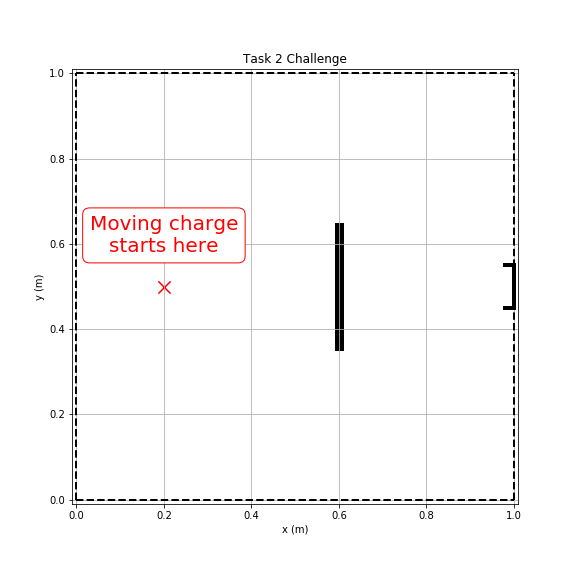


Image also viewable at https://i.ibb.co/92TMt10/one-barrier.png

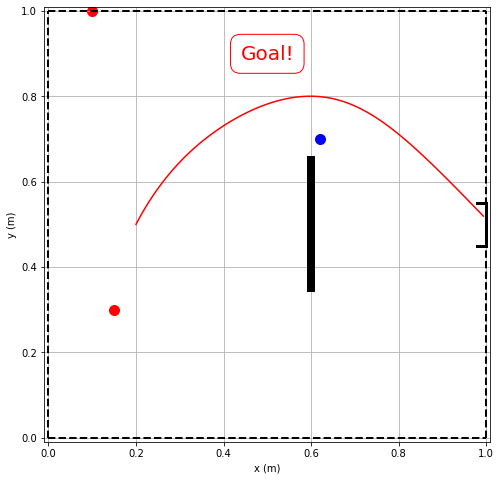

It is True that a goal was scored


In [6]:
### Solution using a non-terminal event to identify an event
### when the particle passes the barrier and then after solve_ivp
### has completed to determine if there was a collision occurred. 

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# A single event function for all four edges of the play area
def out_all(t, state):
    x, y, vx, vy = state
    # All of these values will be positive when inside the box and
    # one of them will go negative when it leaves the box
    return min(x, 1-x, y, 1-y)
out_all.terminal = True
out_all.direction = 0 

# New non-teriminal function for the line of the cbarrier being crossed
def hit_barrier1(t, state):
    x, y, vx, vy = state
    return x - barrier1[0]
hit_barrier1.terminal = False
hit_barrier1.direction = 0 

# The physics
def diff_eqns(t, state):
    
    x, y, vx, vy = state
    
    fx, fy = 0, 0
    for charge in fixed_charges:
        r = np.sqrt((x - charge[0]) ** 2 + (y - charge[1]) ** 2)
        if charge[2] == 'r': 
            dir = 1.
        else:
            dir = -1.
        fx += dir * k * q**2 / r**3 * (x-charge[0])
        fy += dir * k * q**2 / r**3 * (y-charge[1])

    ax, ay = fx / m, fy / m
    
    return vx, vy, ax, ay

# Function to run the simulation
def run_sim3():

    # Times to be simulated
    t0, tmax, dt = 0, 2, 0.001  # seconds
    t_span = (t0, tmax) # from t=0 to t=2
    n_steps = int((tmax-t0)/dt+1) 
    times = np.linspace(t0, tmax, n_steps) 
    
    # Call solve_ivp but keep time info from Task 1
    sol = solve_ivp(diff_eqns, t_span, state0, t_eval=times,
                    events=[out_all, hit_barrier1] )

    sol_t = sol.t
    sol_x = sol.y[0]
    sol_y = sol.y[1]


    # Check for goal
    x_final, y_final, t_final = sol_x[-1], sol_y[-1], sol_t[-1]
    if x_final > 0.99 and goal_dim[1][0] <= y_final <= goal_dim[1][1]:
        goal_text = "Goal!"
    else:
        goal_text = "No goal :("

    # Check for hit_barrier1 that actually hits the barrier
    t_barrier_array = sol.t_events[1] # 2nd function in events list
    y_barrier_array = sol.y_events[1] # 2nd function in events list
    if t_barrier_array.size > 0:
        # Loop through all barrier events since it is possible to go around and hit the back
        for i, y_barrier in enumerate(y_barrier_array):
            # Check moving charge's y-position relative to barrier
            if barrier1[1] < y_barrier[1] < barrier1[2]: 
                # Use the time it hits the barrier to truncate our solution arrays
                t_barrier =  t_barrier_array[i]
                # Keep only times up to and including when the barrier is hit
                sol_t = sol_t[sol_t <= t_barrier] 
                # Apply the length of this new sol_t array to the sol_x and sol_y arrays
                # so that the plot only show up to when the barrier is hit
                n = len(sol_t) 
                sol_x = sol_x[:n]
                sol_y = sol_y[:n]
                # Override any previous barrier text
                goal_text = "Hit barrier :("


    # Plot everything    
    fig, ax = plt.subplots(figsize=(8, 8))

    ax.plot(sol_x, sol_y, color='r')
    ax.grid(True)

    # Draw sidelines and the goal
    for x1, y1, x2, y2 in [(1., 0, 1., 1), (0, 0, 0, 1), (0, 0, 1., 0), (0, 1., 1., 1.)]:
        ax.plot([x1, x2], [y1, y2], color='k', linestyle='--', linewidth=2)
    ax.plot([goal_dim[0][1], goal_dim[0][1]], [goal_dim[1][0], goal_dim[1][1]], color = 'k', linewidth = 3)
    ax.plot([goal_dim[0][0], goal_dim[0][1]], [goal_dim[1][1],goal_dim[1][1]], color = 'k', linewidth = 3)
    ax.plot([goal_dim[0][0], goal_dim[0][1]], [goal_dim[1][0], goal_dim[1][0]], color = 'k', linewidth = 3)

    # Draw barrier
    ax.plot([barrier1[0], barrier1[0]], [barrier1[1], barrier1[2]], color = 'k', linewidth = 8)

    # Plot charges
    for charge in fixed_charges:
        ax.scatter(charge[0], charge[1], color=charge[2], s=100)

    # Set labels, limits, and show the plot
    ax.set_xlabel('x (m)')
    ax.set_ylabel('y (m)')
    ax.set_xlim([-0.01, 1.01])
    ax.set_ylim([-0.01, 1.01])

    plt.text(.5, .9, goal_text, color='red', ha='center', va='center', fontsize=20,
             bbox=dict(facecolor='white', edgecolor='red', boxstyle='round,pad=0.5'))

    plt.show()
    
    if goal_text == "Goal!":
        return True
    return False

# Constants
k = 8.9875517923e9  # Coulomb's constant; N*m^2/C^2
q = 1e-6  # Base charge is 1 uC
m = 1e-3  # Base mass is 1 g

# Initial conditions
state0 = [0.2, 0.5, 0, 0]
fixed_charges = [[0.15, 0.3, 'r'], [0.1, 1.0, 'r'], [0.62, 0.7, 'b']]
barrier1 = [.6, .35, .65] # x, y1, y2
goal_dim = [[.98, 1.],[.45, .55]]

# Run the sim for a goal
goal_status = run_sim3()
print ("It is", goal_status,"that a goal was scored" )

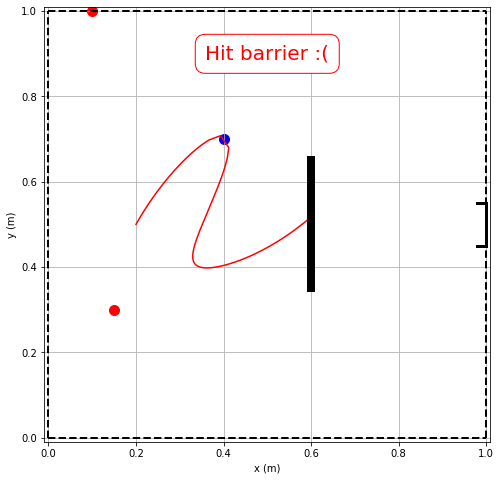

It is False that a goal was scored


In [7]:
# Run the sim for a barrier hit
fixed_charges = [[0.15, 0.3, 'r'], [0.1, 1.0, 'r'], [0.4, 0.7, 'b']]
goal_status = run_sim3()
print ("It is", goal_status,"that a goal was scored" )

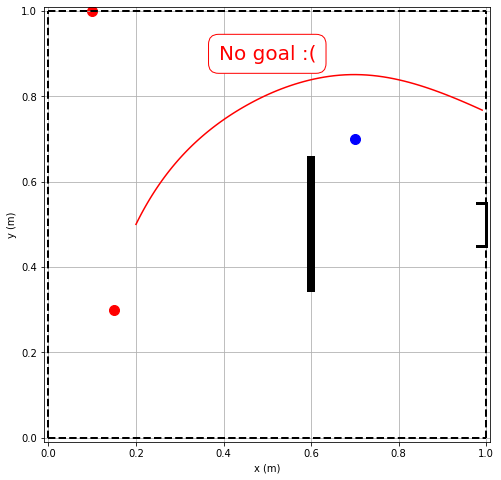

It is False that a goal was scored


In [8]:
# Run the sim for barrier miss no goal
fixed_charges = [[0.15, 0.3, 'r'], [0.1, 1.0, 'r'], [0.7, 0.7, 'b']]
barrier1 = [.6, .35, .65] # x, y1, y2
goal_status = run_sim3()
print ("It is", goal_status,"that a goal was scored" )

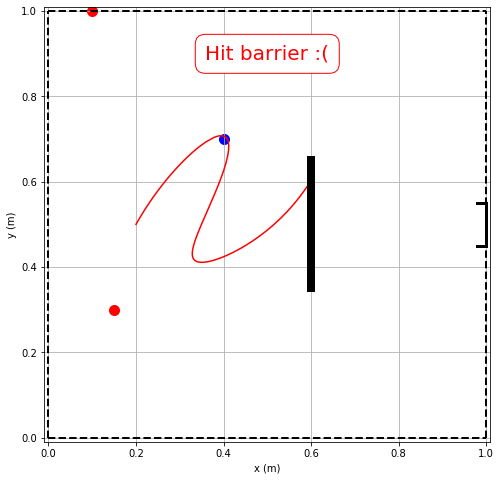

It is False that a goal was scored


In [9]:
# Solution using a terminal event and max_step instead
# of t_eval to ensure that when the charged particle
# passes through the barrier it is detected

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# A single event function for all four edges of the play area
def out_all(t, state):
    x, y, vx, vy = state
    # All of these values will be positive when inside the box and
    # one of them will go negative when it leaves the box
    return min(x, 1-x, y, 1-y)
out_all.terminal = True
out_all.direction = 0 

# New non-teriminal function for the line of the cbarrier being crossed
def hit_barrier_alt(t, state):
    x, y, vx, vy = state
    dx = 0.001 # half-width of the barrier
    
    # Check if it lands "inside" the barrier and return 1
    if barrier1[0]-dx < x < barrier1[0]+dx:
        if barrier1[1] < y < barrier1[2]:
            return 1
    # Otherwise return -1
    return -1

hit_barrier_alt.terminal = True

# The physics
def diff_eqns(t, state):
    
    # Constants
    k = 8.9875517923e9  # Coulomb's constant; N*m^2/C^2
    q = 1e-6  # Base charge is 1 uC
    m = 1e-3  # Base mass is 1 g
    
    x, y, vx, vy = state
    
    fx, fy = 0, 0
    for charge in fixed_charges:
        r = np.sqrt((x - charge[0]) ** 2 + (y - charge[1]) ** 2)
        if charge[2] == 'r': 
            dir = 1.
        else:
            dir = -1.
        fx += dir * k * q**2 / r**3 * (x-charge[0])
        fy += dir * k * q**2 / r**3 * (y-charge[1])

    ax, ay = fx / m, fy / m
    
    return vx, vy, ax, ay

# Function to run the simulation
def run_sim4():

    # Times to be simulated
    t0, tmax, dt = 0, 2, 0.001  # seconds
    t_span = (t0, tmax) # from t=0 to t=2
    
    # Call solve_ivp but keep time info from Task 1
    sol = solve_ivp(diff_eqns, t_span, state0, max_step = dt,
                    events=[out_all, hit_barrier_alt] )

    sol_t = sol.t
    sol_x = sol.y[0]
    sol_y = sol.y[1]


    # Check for goal
    x_final, y_final, t_final = sol_x[-1], sol_y[-1], sol_t[-1]
    if x_final > 0.99 and goal_dim[1][0] <= y_final <= goal_dim[1][1]:
        goal_text = "Goal!"
    else:
        goal_text = "No goal :("

    # Update goal_text if it hit the barrier
    t_barrier_array = sol.t_events[1] # 2nd function in events list
    if t_barrier_array.size > 0:
        goal_text = "Hit barrier :("


    # Plot everything    
    fig, ax = plt.subplots(figsize=(8, 8))

    ax.plot(sol_x, sol_y, color='r')
    ax.grid(True)

    # Draw sidelines and the goal
    for x1, y1, x2, y2 in [(1., 0, 1., 1), (0, 0, 0, 1), (0, 0, 1., 0), (0, 1., 1., 1.)]:
        ax.plot([x1, x2], [y1, y2], color='k', linestyle='--', linewidth=2)
    ax.plot([goal_dim[0][1], goal_dim[0][1]], [goal_dim[1][0], goal_dim[1][1]], color = 'k', linewidth = 3)
    ax.plot([goal_dim[0][0], goal_dim[0][1]], [goal_dim[1][1],goal_dim[1][1]], color = 'k', linewidth = 3)
    ax.plot([goal_dim[0][0], goal_dim[0][1]], [goal_dim[1][0], goal_dim[1][0]], color = 'k', linewidth = 3)

    # Draw barrier
    ax.plot([barrier1[0], barrier1[0]], [barrier1[1], barrier1[2]], color = 'k', linewidth = 8)

    # Plot charges
    for charge in fixed_charges:
        ax.scatter(charge[0], charge[1], color=charge[2], s=100)

    # Set labels, limits, and show the plot
    ax.set_xlabel('x (m)')
    ax.set_ylabel('y (m)')
    ax.set_xlim([-0.01, 1.01])
    ax.set_ylim([-0.01, 1.01])

    plt.text(.5, .9, goal_text, color='red', ha='center', va='center', fontsize=20,
             bbox=dict(facecolor='white', edgecolor='red', boxstyle='round,pad=0.5'))

    plt.show()
    
    if goal_text == "Goal!":
        return True
    return False

# Initial conditions
state0 = [0.2, 0.5, 0, 0]
fixed_charges = [[0.15, 0.3, 'r'], [0.1, 1.0, 'r'], [0.4, 0.7, 'b']]
barrier1 = [.6, .35, .65] # x, y1, y2
goal_dim = [[.98, 1.],[.45, .55]]

# Run the sim for a goal
goal_status = run_sim4()
print ("It is", goal_status,"that a goal was scored" )

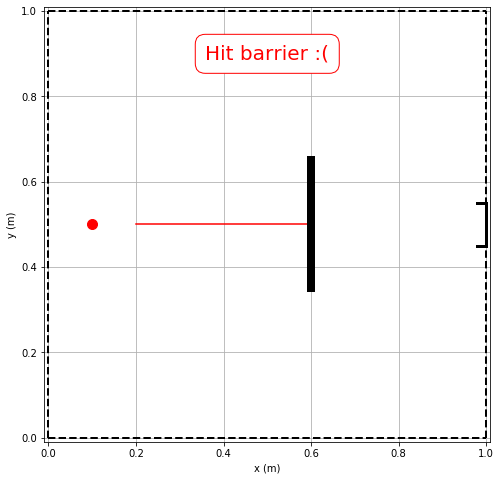

It is False that a goal was scored


In [10]:
# Run the sim for another barrier hit
fixed_charges = [[0.1, 0.5, 'r']]
goal_status = run_sim4()
print ("It is", goal_status,"that a goal was scored" )

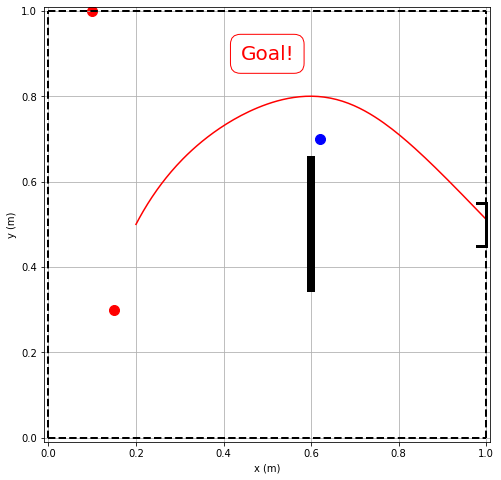

It is True that a goal was scored


In [11]:
# Run the sim for a goal
fixed_charges = [[0.15, 0.3, 'r'], [0.1, 1.0, 'r'], [0.62, 0.7, 'b']]
goal_status = run_sim4()
print ("It is", goal_status,"that a goal was scored" )

### Task 3: Turn the rest of your code into a function that accepts the `state0` and `fixed_charges` lists as arguments, and returns if a goal was scored or not

Another task that is going to be very helpful for your work on Homework 02 is to be able to efficiently try multiple different sets of `state0` variables and receive feedback regarding if a goal was scored or not.

Update/reconfigure your code so that you have a main function (e.g., `electric_field_hockey()`) that calls `solve_ivp`, does all of the plotting, and returns a value indicating if a goal was scored or not. You should be able to run the whole simulation by simply setting the `state0` and `fixed_charges` lists and then calling your main function similar to the example below:
```python
state0 = [0.2, 0.5, 0, 0]
fixed_charges = [[0.15, 0.3, 'r']]
goal_status = electric_field_hockey(state0, fixed_charges)
```

In [12]:
# Multiple variations of this type of code above

### Task 4 (optional): Score a goal around a more complicated barrier

Use the same `state0` and `goal_dim` lists from Task 2, make a setup that has the followig two barriers instead:
* Introduce a barrier, at `x = .0.4` and which spans `(y1, y2) = (0.5, 0.8)`
* Introduce a barrier, at `x = .0.7` and which spans `(y1, y2) = (0.3, 0.6)`. 

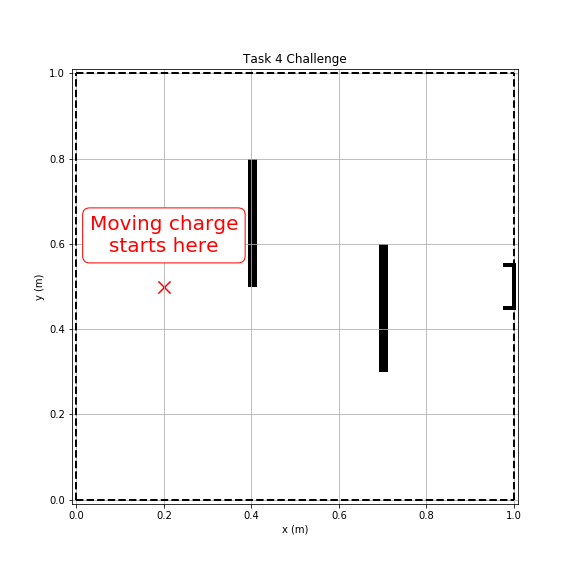

The image is also viewable at https://i.ibb.co/KrHqfvH/two-barriers.png

In [13]:
# No solutions provided



# Code to make the Task 2 and 4 challenge plots

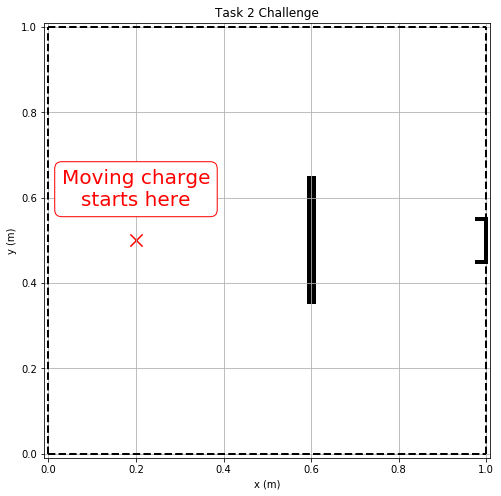

In [14]:
## Solution

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Constants
k = 8.9875517923e9 # Coulomb's constant; N*m^2/C^2
q0 = 1e-6 # Base charge is 1 uC
m0 = 1e-3 # Base mass is 1 g
constants = [k, q0, m0]
goal_dim = [[.98, 1.],[.45, .55]]

# Plotting
fig, ax = plt.subplots(figsize=(8, 8))


# Draw sidelines and the goal
for x1, y1, x2, y2 in [(1., 0, 1., 1), (0, 0, 0, 1), (0, 0, 1., 0), (0, 1., 1., 1.)]:
    ax.plot([x1, x2], [y1, y2], color='k', linestyle='--', linewidth=2)
ax.plot([goal_dim[0][1], goal_dim[0][1]], [goal_dim[1][0], goal_dim[1][1]], color = 'k', linewidth = 4)
ax.plot([goal_dim[0][0], goal_dim[0][1]], [goal_dim[1][1],goal_dim[1][1]], color = 'k', linewidth = 4)
ax.plot([goal_dim[0][0], goal_dim[0][1]], [goal_dim[1][0], goal_dim[1][0]], color = 'k', linewidth = 4)


ax.scatter(0.2, 0.5, color='r', s=150, marker='x')

# Set labels, limits, and show the plot
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
ax.set_xlim([-.01, 1.01])
ax.set_ylim([-.01, 1.01])
ax.set_title('Task 2 Challenge')

goal_text = f"Moving charge\nstarts here"
plt.text(.2, .62, goal_text, color='red', ha='center', va='center', fontsize=20,
         bbox=dict(facecolor='white', edgecolor='red', boxstyle='round,pad=0.35'))

#barrier1 = [.6, .35, .65]
#ax.plot([barrier1[0], barrier1[0]], [barrier1[1], barrier1[2]], color = 'k', linewidth = 8)


ax.add_patch(patches.Rectangle((.59125, .35), .02, .3, facecolor='black'))


ax.grid(True)
#plt.savefig('one_barrier.png')
plt.show()

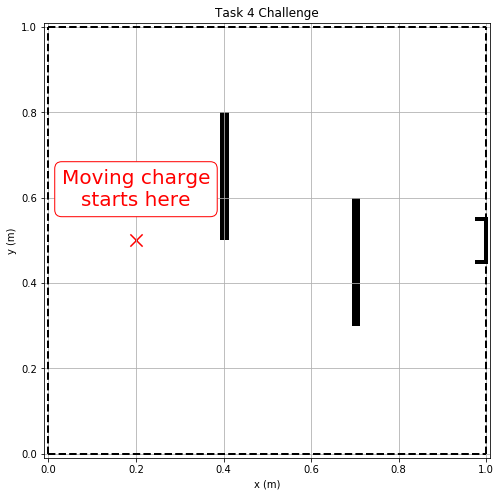

In [15]:
## Solution

import numpy as np
import matplotlib.pyplot as plt

# Constants
k = 8.9875517923e9 # Coulomb's constant; N*m^2/C^2
q0 = 1e-6 # Base charge is 1 uC
m0 = 1e-3 # Base mass is 1 g
constants = [k, q0, m0]
goal_dim = [[.98, 1.],[.45, .55]]

# Plotting
fig, ax = plt.subplots(figsize=(8, 8))


# Draw sidelines and the goal
for x1, y1, x2, y2 in [(1., 0, 1., 1), (0, 0, 0, 1), (0, 0, 1., 0), (0, 1., 1., 1.)]:
    ax.plot([x1, x2], [y1, y2], color='k', linestyle='--', linewidth=2)
ax.plot([goal_dim[0][1], goal_dim[0][1]], [goal_dim[1][0], goal_dim[1][1]], color = 'k', linewidth = 4)
ax.plot([goal_dim[0][0], goal_dim[0][1]], [goal_dim[1][1],goal_dim[1][1]], color = 'k', linewidth = 4)
ax.plot([goal_dim[0][0], goal_dim[0][1]], [goal_dim[1][0], goal_dim[1][0]], color = 'k', linewidth = 4)


ax.scatter(0.2, 0.5, color='r', s=150, marker='x')

# Set labels, limits, and show the plot
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
ax.set_xlim([-.01, 1.01])
ax.set_ylim([-.01, 1.01])

goal_text = f"Moving charge\nstarts here"
plt.text(.2, .62, goal_text, color='red', ha='center', va='center', fontsize=20,
         bbox=dict(facecolor='white', edgecolor='red', boxstyle='round,pad=0.35'))

#barrier1 = [.4, .5, .8]
#ax.plot([barrier1[0], barrier1[0]], [barrier1[1], barrier1[2]], color = 'k', linewidth = 8)
#barrier2 = [.7, .3, .6]
#ax.plot([barrier2[0], barrier2[0]], [barrier2[1], barrier2[2]], color = 'k', linewidth = 8)

ax.add_patch(patches.Rectangle((.3925, .5), .02, .3, facecolor='black'))
ax.add_patch(patches.Rectangle((.6925, .3), .02, .3, facecolor='black'))

ax.set_title('Task 4 Challenge')

ax.grid(True)
#plt.savefig('two_barriers.png')
plt.show()